In [1]:
%matplotlib inline  
# Load the libraries
import glob2, re
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap

import nbimporter
from Simulation_Analysis_Foraging import *

Importing Jupyter notebook from Simulation_Analysis_Foraging.ipynb


# Color palette for figures 

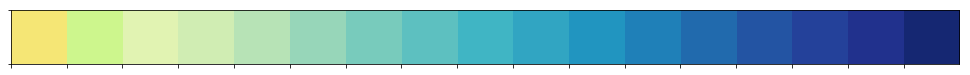

In [6]:
color_map = sns.color_palette("YlGnBu", n_colors=len(ROBOT_RANGE))
color_map = color_map.as_hex()
color_map[0] = '#f5e675'
color_map[1] = '#cdf68d'

#color_map = sns.cubehelix_palette(n_colors=len(ROBOT_RANGE), light=0.7, rot=-0.4)

linestyles = ['-', '--', '-.', ':', '-']
markers=['x', ',', '^', 'o', '.']
loosely_dotted = (0, (5,10))
linestyles = ['solid','dashed','dashdot','dotted',loosely_dotted]
sns.palplot(color_map)

In [4]:
# Specify the file paths and the list of all sim data files 
path=r'/Users/eddie/maze-formation-epuck-sim' # use your path
ALL_FILES = glob2.glob(path + "/*/*/*/*/*.dat")

# Filter up to what simulation do you want to consider
SIM_THRESHOLD = 100
for _file in ALL_FILES:
    substring = re.findall(r'SIM\d+', _file)
    current_sim_number = substring[0].strip('SIM')
    if int(current_sim_number) > SIM_THRESHOLD:
        ALL_FILES.remove(_file)

In [5]:
# Specify the search terms for filtering the files
ROBOT_RANGE = range(16,33)
TOKEN_RANGE = range(16,17)
DENSITY_OF_TOKENS = '\d'
TIMEOUT_THRESHOLD = 10000

# Matrix Creation
FINISHING_TIMES = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]
SUCCESS_PERCENTAGES = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]

# Matrix Value Calculation
for x, NUMBER_OF_ROBOTS in enumerate(ROBOT_RANGE):
    for y, NUMBER_OF_TOKENS in enumerate(TOKEN_RANGE):
        FINISHING_TIMES[x][y] = FinishingTimesLastToCompleteMerkleTree(NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, DENSITY_OF_TOKENS, TIMEOUT_THRESHOLD, ALL_FILES)       
        SUCCESS_PERCENTAGES[x][y] = CompletionSuccess(TIMEOUT_THRESHOLD, FINISHING_TIMES[x][y])

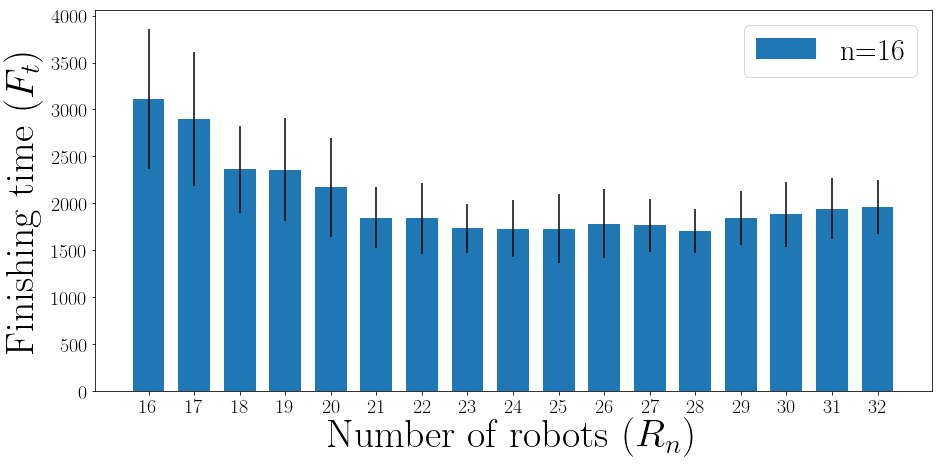

In [55]:
# Finishing Time Calculation
plt.figure(figsize=(15,7))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

bar_width = 0.7
opacity = 0.4

for y, NUMBER_OF_TOKENS in enumerate(TOKEN_RANGE):
    robot_array =[d2[y] for d2 in [d1[:] for d1 in FINISHING_TIMES]]
    rr = np.array(ROBOT_RANGE)
    plt.bar(rr+(bar_width*y), map(np.mean, zip(robot_array)), bar_width, yerr=map(np.std, zip(robot_array)), label='n='+str(NUMBER_OF_TOKENS))
    plt.legend(loc=1, prop={'size': 30})
    
plt.tick_params(labelsize=20)
plt.xticks(rr, ('16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32'))
plt.xlabel('Number of robots' + ' ' +  r'$(R_{n})$' , fontsize=40)
plt.ylabel('Finishing time' + ' ' + r'$(F_{t})$', fontsize=40)
plt.show()

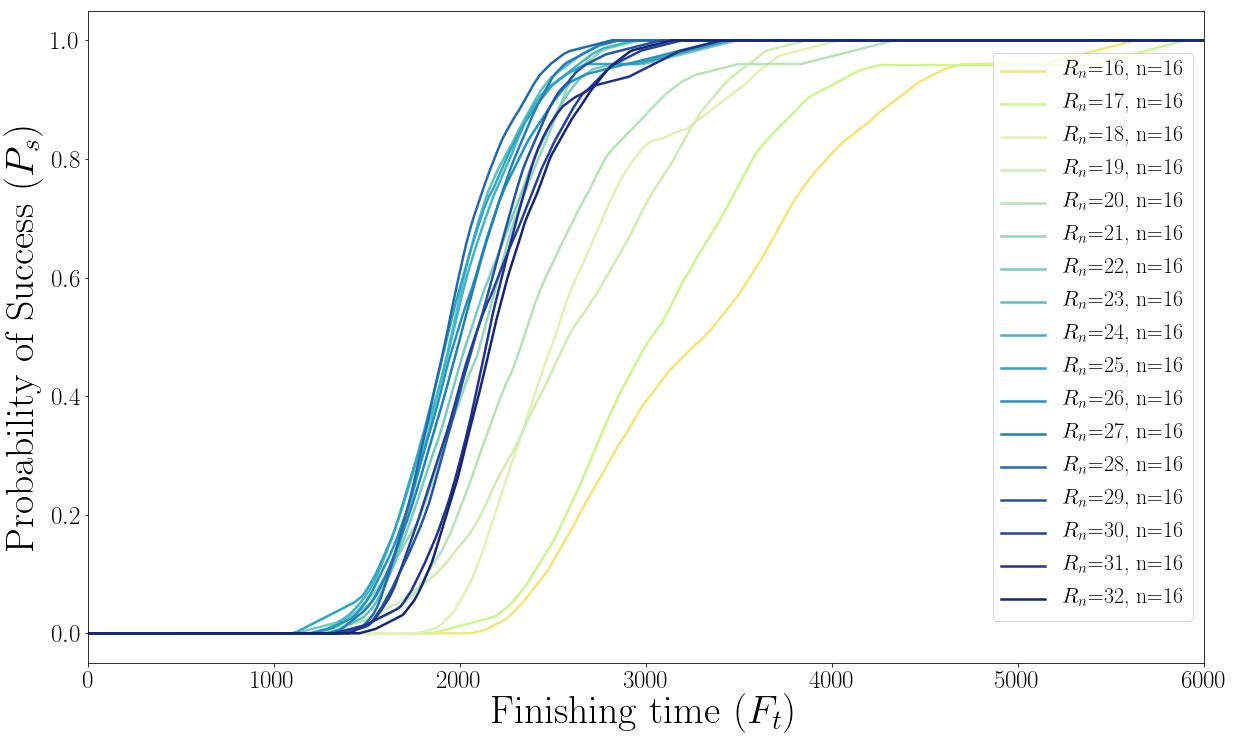

In [91]:
pairs = [(i,j) for i in range(len(ROBOT_RANGE)) for j in range(len(TOKEN_RANGE))]

def interpolate(xnew, pair, SUCCESS_PERCENTAGES):
    xnew[0][225] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][225]
    xnew[0][200] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][200]
    xnew[0][100] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][100]
    xnew[0][0] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][0]
    return xnew

# Success rate calculation
plt.figure(figsize=(20,12))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

for pair in pairs:
    xnew = pd.DataFrame(SUCCESS_PERCENTAGES[pair[0]][pair[1]]).rolling(500).mean()
    xnew = interpolate(xnew, pair, SUCCESS_PERCENTAGES)
    xnew = xnew.interpolate()
    xnew.dropna(inplace=True)
    #plt.plot(xnew, color=color_map[pair[0]], ls=linestyles[pair[1]], label = "_nolegend")
    plt.plot(xnew, color=color_map[pair[0]], lw=2.5, ls=linestyles[pair[1]], label= str(r'$R_{n}$='+ str(pair[0]+min(ROBOT_RANGE)) + ', n=' + str(pair[1]+min(TOKEN_RANGE))))
    plt.legend(prop={'weight':'bold'})

plt.tick_params(labelsize=25)
plt.xlabel('Finishing time' + ' ' + r'$(F_{t})$', fontsize=40)
plt.ylabel('Probability of Success' + ' ' + r'$(P_{s})$', fontsize=40, fontweight='bold')
plt.xlim([0,6000])
legend_properties = {'size': 22, 'weight': 'bold'}
plt.legend(ncol=1, loc="right", prop=legend_properties)
plt.show()

## Communication Cost and Information diversity

In [46]:
# Specify the file paths and the list of all sim data files 
ALL_FILES_JSON = glob2.glob(path + "/*/*/*/*/*.json")

# Filter up to what simulation do you want to consider
SIM_THRESHOLD = 25
for _file in ALL_FILES_JSON:
    substring = re.findall(r'SIM\d+', _file)
    current_sim_number = substring[0].strip('SIM')
    if int(current_sim_number) > SIM_THRESHOLD:
        ALL_FILES_JSON.remove(_file)

In [47]:
def ExtractCommunicationGraphEndOfExperiment(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_LEAVES, SIM_FILE):    
    data = pd.read_json(SIM_FILE)
    rows, columns = data.shape
    G = nx.DiGraph()

    for robotid in xrange(INITIAL_ID, INITIAL_ID + NUMBER_OF_ROBOTS):
        G.add_node(robotid)
        from_robots = data['robots'][rows-1][robotid - INITIAL_ID]['mk']['from_robot']           
        for other_robot in unique(from_robots):
            G.add_edge(other_robot, robotid, weight=Counter(from_robots)[other_robot])          
    return G

In [48]:
def CommunicationCostinKB(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, HASH_SIZE_IN_BYTES, FILTERED_FILES):
    CC = []
    GR = []
    for x, file in enumerate(FILTERED_FILES):
        GR.append(ExtractCommunicationGraphEndOfExperiment(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, file))
        CC.append(CommunicationCostCalculation(GR[-1], NUMBER_OF_TOKENS, HASH_SIZE_IN_BYTES)/1024)
    return GR, CC

In [49]:
CC = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]
PR = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]
GR = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]

HASH_SIZE_IN_BYTES = 32
INITIAL_ID = 20

# Matrix Value Calculation
for x, NUMBER_OF_ROBOTS in enumerate(ROBOT_RANGE):
    for y, NUMBER_OF_TOKENS in enumerate(TOKEN_RANGE):
        
        regex = re.compile(r'R' + str(NUMBER_OF_ROBOTS) + '/' + 'T'+ str(NUMBER_OF_TOKENS) + '/' + 'D'+ str(DENSITY_OF_TOKENS))    
        FILTERED_FILES = filter(regex.search, ALL_FILES_JSON)
        
        GR[x][y], CC[x][y] = CommunicationCostinKB(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, HASH_SIZE_IN_BYTES, FILTERED_FILES)
        PR[x][y] = PrivacyCoeff(NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, FILTERED_FILES)

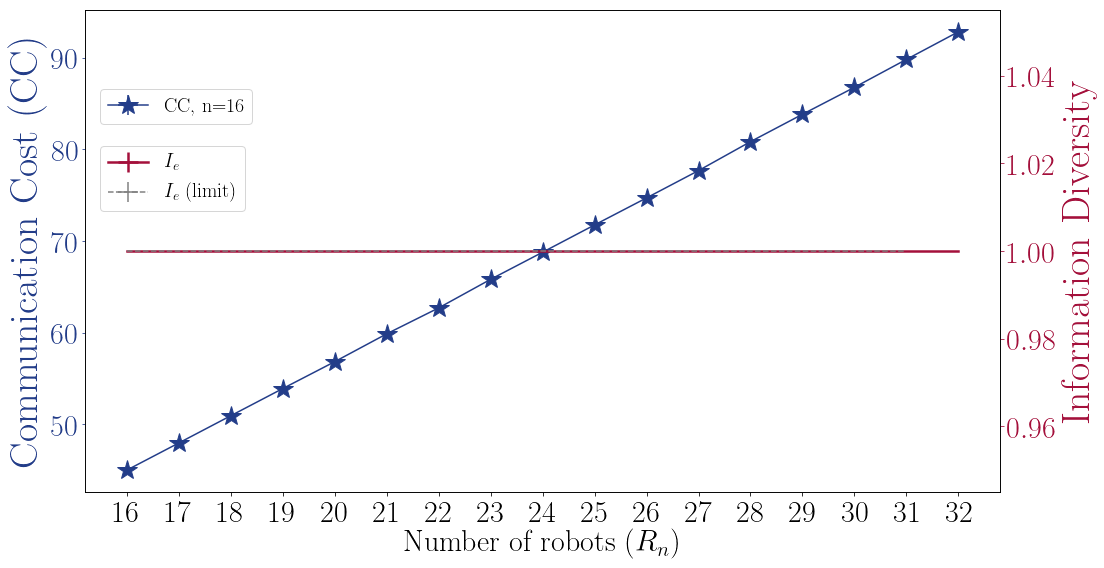

In [84]:
# Communication Cost Vs Information Diversity
fig, ax1 = plt.subplots(figsize=(15,8))

robot_row = []
robot_row_std = []

for x, NUMBER_OF_ROBOTS in enumerate(ROBOT_RANGE):
    robot_ = [(np.nanmean(col)) for col in zip(CC[x])]
    robot_row.append(np.nanmean(robot_))
    robot_row_std.append(np.nanstd(robot_))

ax1.errorbar(ROBOT_RANGE, robot_row, xerr=0, yerr=robot_row_std, marker='*', markersize=20, color='#233D89',label='CC, n=16') 
ax1.set_xlabel('Number of robots' + ' ' +  r'$(R_{n})$', fontsize=30)
plt.legend(loc='center left',prop={'size': 20}, bbox_to_anchor=(0.005, 0.80))

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Communication Cost (CC)', color='#233D89', fontsize=40)
ax1.tick_params('y', colors='#233D89')
plt.tick_params(labelsize=30)
plt.xticks(tuple((i) for i in ROBOT_RANGE))

ax2 = ax1.twinx()
robot_row = []
robot_row_std = []

for x, NUMBER_OF_ROBOTS in enumerate(ROBOT_RANGE):
    robot_ = [np.mean(col) for col in zip(PR[x])]
    robot_row.append(np.nanmean(robot_))
    robot_row_std.append(np.nanstd(robot_))

# Privacy
ax2.errorbar(ROBOT_RANGE, robot_row, xerr=0, yerr=robot_row_std, c='#A4103B', markersize=20, lw=2.5, label=str(r'$I_{e}$')) 

# Limit for Privacy
ax2.errorbar(range(16,32), np.ones(16), xerr=0, yerr=0, c='grey', ls='dashed', markersize=20, label=str(r'$I_{e}$ (limit)')) 
ax2.set_ylabel('Information Diversity', color='#A4103B', fontsize=40)
plt.legend(loc='center left',prop={'size': 20}, bbox_to_anchor=(0.005, 0.65))
ax2.tick_params('y', colors='#A4103B')
fig.tight_layout()
plt.tick_params(labelsize=30)
plt.show()

In [7]:
SIMULATION_FINISHING_TIMES = FINISHING_TIMES
SIMULATION_COMMUNICATION_COST = CC
SIMULATION_INFORMATION_DIVERSITY = PR

%store SIMULATION_FINISHING_TIMES
%store SIMULATION_COMMUNICATION_COST
%store SIMULATION_INFORMATION_DIVERSITY

NameError: name 'CC' is not defined